*本节在 **车杆（CartPole）离散-动作**交互环境下进行 **TRPO** 代码实践*

导入相关库：

In [1]:
# 基本库
import numpy as np
import copy

from utils.smoothing import moving_average
from utils.advantage import compute_advantage
from utils.training import train_on_policy_agent
# 神经网络
import torch
import torch.nn.functional as F
# Gymnasium 是一个用于开发和测试强化学习算法的工具库，为 OpenAI Gym 的更新版本（2021迁移开发）
import gymnasium as gym

## 车杆环境（'CartPole-v1'）

### 定义策略网络和价值网络（与 Actor-Critic 算法一样）:

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

### 定义 TRPO 算法（离散动作）：

In [3]:
class TRPO:
    """ 处理离散动作的TRPO算法 """
    def __init__(self, hidden_dim, state_space, action_space, lmbda, kl_constraint, alpha, critic_lr, gamma, device):
        
        state_dim = state_space.shape[0]
        action_dim = action_space.n
    
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        # 策略网络参数不需要优化器去更新
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        
        self.gamma = gamma
        self.lmbda = lmbda                  # GAE参数
        self.kl_constraint = kl_constraint  # KL距离最大限制
        self.alpha = alpha                  # 线性搜索参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def hessian_matrix_vector_product(self, states, old_action_dists, vector):  # 计算Hansen矩阵和一个向量的乘积
        new_action_dists = torch.distributions.Categorical(self.actor(states))
        kl = torch.mean(torch.distributions.kl.kl_divergence(old_action_dists, new_action_dists))  # 计算平均KL距离
        kl_grad = torch.autograd.grad(kl, self.actor.parameters(), create_graph=True)
        kl_grad_vector = torch.cat([grad.view(-1) for grad in kl_grad])
        # KL距离的梯度先和向量进行点积运算
        kl_grad_vector_product = torch.dot(kl_grad_vector, vector)
        # 再求导，即得海森矩阵与向量的乘积（无需显式构造 Hessian）
        grad2 = torch.autograd.grad(kl_grad_vector_product, self.actor.parameters())
        grad2_vector = torch.cat([grad.view(-1) for grad in grad2])
        return grad2_vector

    def conjugate_gradient(self, grad, states, old_action_dists):  # 共轭梯度法求解方程
        x = torch.zeros_like(grad)
        r = grad.clone()
        p = grad.clone()
        rdotr = torch.dot(r, r)
        for i in range(10):  # 共轭梯度主循环
            Hp = self.hessian_matrix_vector_product(states, old_action_dists,p)
            alpha = rdotr / torch.dot(p, Hp)
            x += alpha * p
            r -= alpha * Hp
            new_rdotr = torch.dot(r, r)
            if new_rdotr < 1e-10:
                break
            beta = new_rdotr / rdotr
            p = r + beta * p
            rdotr = new_rdotr
        return x

    def compute_surrogate_obj(self, states, actions, advantage, old_log_probs, actor):  # 计算策略目标函数
        log_probs = torch.log(actor(states).gather(1, actions))
        ratio = torch.exp(log_probs - old_log_probs)
        return torch.mean(ratio * advantage)

    def line_search(self, states, actions, advantage, old_log_probs, old_action_dists, max_vec):  # 线性搜索
        
        old_para = torch.nn.utils.convert_parameters.parameters_to_vector(self.actor.parameters())
        old_obj = self.compute_surrogate_obj(states, actions, advantage, old_log_probs, self.actor)
        
        for i in range(15):  # 线性搜索主循环
            coef = self.alpha**i
            new_para = old_para + coef * max_vec
            new_actor = copy.deepcopy(self.actor)  # 策略网络深层拷贝，防止后面的操作改变原始网络参数
            torch.nn.utils.convert_parameters.vector_to_parameters(new_para, new_actor.parameters())
            new_action_dists = torch.distributions.Categorical(new_actor(states))
            kl_div = torch.mean(torch.distributions.kl.kl_divergence(old_action_dists, new_action_dists))
            new_obj = self.compute_surrogate_obj(states, actions, advantage, old_log_probs, new_actor)
            if new_obj > old_obj and kl_div < self.kl_constraint:
                return new_para
        return old_para

    def policy_learn(self, states, actions, old_action_dists, old_log_probs, advantage):  # 更新策略网络
        surrogate_obj = self.compute_surrogate_obj(states, actions, advantage, old_log_probs, self.actor)
        grads = torch.autograd.grad(surrogate_obj, self.actor.parameters())
        obj_grad = torch.cat([grad.view(-1) for grad in grads]).detach()
        
        descent_direction = self.conjugate_gradient(obj_grad, states, old_action_dists)  # 用共轭梯度法计算x = H^(-1)g
        Hx = self.hessian_matrix_vector_product(states, old_action_dists, descent_direction)
        max_coef = torch.sqrt(2 * self.kl_constraint / (torch.dot(descent_direction, Hx) + 1e-8))  # 理论最大步长
        new_para = self.line_search(states, actions, advantage, old_log_probs, old_action_dists,
                                    descent_direction * max_coef)  # 线性搜索
        torch.nn.utils.convert_parameters.vector_to_parameters(new_para, self.actor.parameters())  # 用线性搜索后的参数更新策略

    def update(self, transition_dict):
        states_np = np.array(transition_dict['states'])  # 转换成统一的大 np.ndarray，PyTorch更高效处理
        states = torch.tensor(states_np, dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states_np = np.array(transition_dict['next_states'])  # 转换成统一的大 np.ndarray，PyTorch更高效处理
        next_states = torch.tensor(next_states_np, dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)  # 时序差分目标
        td_delta = td_target - self.critic(states)                                 # 时序差分误差
        
        advantage = compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1,actions)).detach()
        old_action_dists = torch.distributions.Categorical(self.actor(states).detach())
        
        # 更新价值函数
        critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()  # 更新价值函数
        
        # 更新策略函数
        self.policy_learn(states, actions, old_action_dists, old_log_probs, advantage)

环境设置（'CartPole-v1'）：

In [4]:
np.random.seed(0)    # 设置 NumPy 的随机种子
torch.manual_seed(0) # 设置 PyTorch CPU 随机种子
torch.cuda.manual_seed_all(0) # 设置 PyTorch GPU 随机种子, 由于GPU并行性, 只能极大减小偏差

env = gym.make('CartPole-v1')  # CartPole-v1 最大回合步数修改到了500步(v0为200)
#env = env.unwrapped # 获取原始环境（绕过 TimeLimit 包装器）解除最大步数500限制
env.reset(seed=0)   # 环境通常依赖于其他随机数生成器来初始化状态、进行探索(推荐位于以上随机之后)
print("Environment spec:", env.spec)

Environment spec: EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, disable_env_checker=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')


超参数设置：

In [5]:
hidden_dim = 128
lmbda = 0.95
# 搜索步伐(方向+距离)控制
kl_constraint = 0.0009  # 限制每次策略更新的“跳跃程度”
alpha = 0.5  # "步长"衰减,越小越"精细"

critic_lr = 1e-2
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device( "cpu")
agent = TRPO(hidden_dim, env.observation_space, env.action_space, lmbda, kl_constraint, alpha, critic_lr, gamma, device)

num_episodes = 1000

测试与训练:

In [6]:
return_list = train_on_policy_agent(env, agent, num_episodes)

Iteration 9: 100%|██████████| 80/80 [00:34<00:00,  2.33it/s, episode=800, return=329.000]


绘图：

In [7]:
import pandas as pd
episodes_list = list(range(len(return_list)))
mv_return = moving_average(return_list, 9)
# 创建 DataFrame
df1 = pd.DataFrame({'Episodes': episodes_list, 'Returns': return_list})
df2 = pd.DataFrame({'Episodes': episodes_list, 'Returns': mv_return})
# 保存为 CSV 文件
df1.to_csv('TRPO_CartPole-v1_returns_data.csv', index=False)
df2.to_csv('TRPO_CartPole-v1_mv_returns_data.csv', index=False)

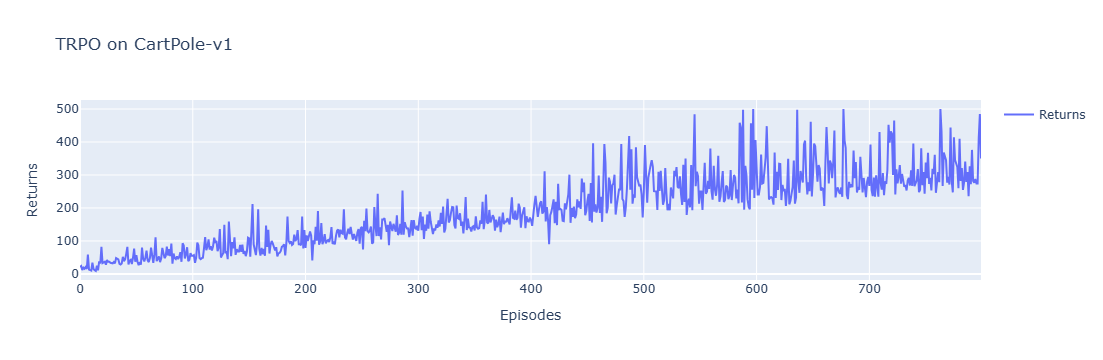

In [8]:
import plotly.graph_objects as go
import pandas as pd
df = pd.read_csv('TRPO_CartPole-v1_returns_data.csv')  # 从 CSV 文件中读取数据
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Episodes'], y=df['Returns'], mode='lines', name='Returns'))
fig.update_layout(
    title='TRPO on CartPole-v1',
    xaxis_title='Episodes',
    yaxis_title='Returns',
    showlegend=True
)
fig.show()

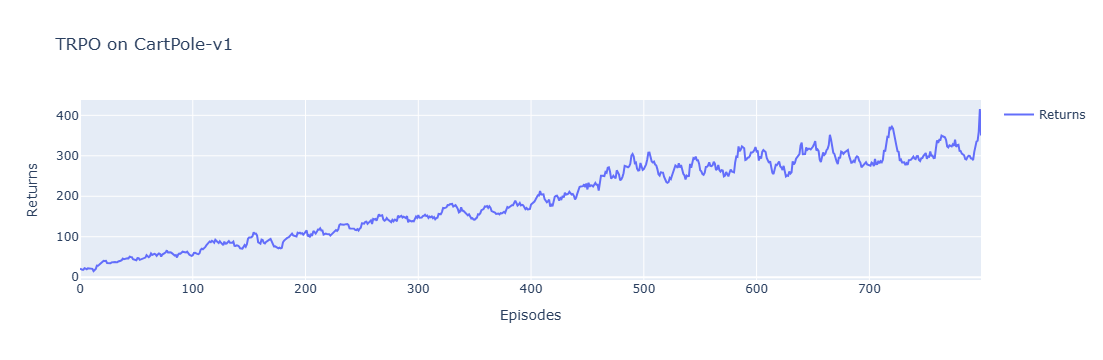

In [9]:
import plotly.graph_objects as go
import pandas as pd
df = pd.read_csv('TRPO_CartPole-v1_mv_returns_data.csv')  # 从 CSV 文件中读取数据
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Episodes'], y=df['Returns'], mode='lines', name='Returns'))
fig.update_layout(
    title='TRPO on CartPole-v1',
    xaxis_title='Episodes',
    yaxis_title='Returns',
    showlegend=True
)
fig.show()